In [111]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [110]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 81.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 76.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.3/296.3 kB 21.1 MB/s eta 0:00:00


In [2]:
import spacy
import scispacy

from scispacy.linking import EntityLinker

nlp = spacy.load("en_core_sci_sm")

# This line takes a while, because we have to download ~1GB of data
# and load a large JSON file (the knowledge base). Be patient!
# Thankfully it should be faster after the first time you use it, because
# the downloads are cached.
# NOTE: The resolve_abbreviations parameter is optional, and requires that
# the AbbreviationDetector pipe has already been added to the pipeline. Adding
# the AbbreviationDetector pipe and setting resolve_abbreviations to True means
# that linking will only be performed on the long form of abbreviations.
nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})

/home/azureuser/miniconda3/envs/spacy/lib/python3.9/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_sci_sm' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2020-10-09/umls/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmpr7nszq8t
Finished download, copying /tmp/tmpr7nszq8t to cache at /home/azureuser/.scispacy/datasets/e9f7327283e43f0482f7c0c71b71dec278a58ccb3ffdd03c2c2350159e7ef146.f2a350ad19015b2591545f7feeed6a6d6d2fffcd635d868a5d7fc0dfc3cadfd8.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2020-10-09/umls/nmslib_index.bin not found in cache, downloading to /tmp/tmprxc60h1x
Finished download, copying /tmp/tmprxc60h1x to cache at /home/azureuser/.scispacy/datasets/f48455d6c79262057cce66b4619123c2b558b21092d42fac97f47bb99a5b8f9f.dd70d3dffe7d90d7ac8914460e16a48375dab32485fb6313a34e6fbcaf53218b.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2020-10-09/umls/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmp37npnn3e
Finished download, copying /tmp/tmp37npnn3e to cache a

/home/azureuser/miniconda3/envs/spacy/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/azureuser/miniconda3/envs/spacy/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2020-10-09/umls/concept_aliases.json not found in cache, downloading to /tmp/tmp1irit92e
Finished download, copying /tmp/tmp1irit92e to cache at /home/azureuser/.scispacy/datasets/1428ec15d3b1061731ea273c03699130b3d6b90948993e74bda66af605ff8e2a.aeb7a686c654df6bccb6c2c23d3eda3eb381daaefda4592b58158d0bee53b352.concept_aliases.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/kbs/2020-10-09/umls_2020_aa_cat0129.jsonl not found in cache, downloading to /tmp/tmpyvpkyrnb
Finished download, copying /tmp/tmpyvpkyrnb to cache at /home/azureuser/.scispacy/datasets/4d7fb8fcae1035d1e0a47d9072b43d5a628057d35497fbfb2499b4b7b2dd4dd7.05ec7eef12f336d4666da85b7fa69b9401883a7dd4244473f7b88b413ccbba03.umls_2020_aa_cat0129.jsonl
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_semantic_type_tree.tsv not found in cache, downloading to /tmp/tmpv5s0ssfx
Finished download, copying /tmp/tmpv5s0ssfx to cache at /home/azureuser

In [10]:
os.getcwd()

'/home/azureuser/austin/scispacy'

In [57]:
df_notes = pd.read_csv("../../NOTEEVENTS_short.csv", nrows=100)
df_diag = pd.read_csv("../../DIAGNOSES_ICD.csv")

In [58]:
linker = nlp.get_pipe("scispacy_linker")
def text2cui(text, threshold=0.7):
    doc = nlp(text)
    cuis = []
    for ent in doc.ents:
        for umls_ent in ent._.kb_ents:
            if umls_ent[1]>=threshold:
                cuis.append(umls_ent[0])
    return list(set(cuis))

df_notes['CUIs'] = df_notes['TEXT'].apply(lambda text: text2cui(text))

In [59]:
all_cuis = list(set(df['CUIs'].sum()))

In [63]:
def cuis2onehot(cuis, all_cuis):
    """takes in a list of CUIS and converts to a combined one hot vector"""
    vec = np.zeros( len(all_cuis) )
    for c in cuis:
        vec[all_cuis.index(c)] = 1
    return vec 

df_notes['CUI Vec'] = df_notes['CUIs'].apply( cuis2onehot, all_cuis=all_cuis)
df


,SUBJECT_ID,HADM_ID,ICD9_CODE,ROW_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,CUIs
0,710,114242,"[0389, 78559, 4275, 5185, 570, 5849, 4280, 516...",245,2182-02-28,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2182-2-18**] Dischar...,"[C3245487, C0809949, C1704241, C1705489, C1578..."
1,710,114242,"[0389, 78559, 4275, 5185, 570, 5849, 4280, 516...",246,2182-02-28,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2182-2-18**] Dischar...,"[C4685200, C0441468, C0032821, C1880496, C0184..."
2,1136,136706,"[42830, 40301, 5856, 4160, 4280, V1005]",187,2194-08-16,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2194-8-15**] ...,"[C1557662, C4685200, C0030704, C3538926, C0746..."
3,1136,139574,"[00845, 42830, 4280, 42731, 40391, 2639, 2875,...",185,2192-05-23,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2192-4-19**] ...,"[C0033707, C1710257, C0301571, C4685200, C0017..."
4,1136,186931,"[40301, 42830, 5855, 2767, 4280, 2859, 53081]",186,2194-05-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2194-5-8**] D...,"[C3275097, C0033707, C0013720, C4685200, C0017..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,93556,154802,"[41401, 2724, 4019]",222,2121-04-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2121-3-31**] ...,"[C0205101, C1882154, C0014792, C0852949, C1547..."
96,93671,119010,"[4238, 486, 1963, 1983, 1970, 1972, 1960, 5559...",203,2180-11-07,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2180-10-29**] ...,"[C0033707, C1458156, C1557662, C0746961, C0053..."
97,96774,129414,"[486, 2761, 27652, 49390, 32723, 4019, 79029, ...",248,2174-02-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2174-2-12**] ...,"[C3275097, C1550457, C4685200, C3538926, C1847..."
98,98046,139402,"[4241, 42843, 2761, 5849, 3342, 41401, 42731, ...",188,2198-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2198-7-17**] ...,"[C3833383, C1557662, C0373527, C0017446, C0037..."


In [64]:
print(df_diag.head())
df_diag_agg = df_diag.groupby(['SUBJECT_ID','HADM_ID'], as_index=False)['ICD9_CODE'].agg(list)
print(df_diag_agg.head())
df = df_diag_agg.merge(df_notes, on=['SUBJECT_ID','HADM_ID'], how='inner')
df.head()

   ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0    1297         109   172335      1.0     40301
1    1298         109   172335      2.0       486
2    1299         109   172335      3.0     58281
3    1300         109   172335      4.0      5855
4    1301         109   172335      5.0      4254
   SUBJECT_ID  HADM_ID                                          ICD9_CODE
0           2   163353                                [V3001, V053, V290]
1           3   145834  [0389, 78559, 5849, 4275, 41071, 4280, 6826, 4...
2           4   185777  [042, 1363, 7994, 2763, 7907, 5715, 04111, V09...
3           5   178980                                [V3000, V053, V290]
4           6   107064  [40391, 4440, 9972, 2766, 2767, 2859, 2753, V1...


,SUBJECT_ID,HADM_ID,ICD9_CODE,ROW_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,CUIs,CUI Vec
0,710,114242,"[0389, 78559, 4275, 5185, 570, 5849, 4280, 516...",245,2182-02-28,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2182-2-18**] Dischar...,"[C3245487, C0809949, C1704241, C1705489, C1578...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,710,114242,"[0389, 78559, 4275, 5185, 570, 5849, 4280, 516...",246,2182-02-28,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2182-2-18**] Dischar...,"[C4685200, C0441468, C0032821, C1880496, C0184...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1136,136706,"[42830, 40301, 5856, 4160, 4280, V1005]",187,2194-08-16,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2194-8-15**] ...,"[C1557662, C4685200, C0030704, C3538926, C0746...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1136,139574,"[00845, 42830, 4280, 42731, 40391, 2639, 2875,...",185,2192-05-23,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2192-4-19**] ...,"[C0033707, C1710257, C0301571, C4685200, C0017...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,1136,186931,"[40301, 42830, 5855, 2767, 4280, 2859, 53081]",186,2194-05-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2194-5-8**] D...,"[C3275097, C0033707, C0013720, C4685200, C0017...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [68]:
all_icd = list(set(df['ICD9_CODE'].sum()))
df['ICD Vec'] = df['ICD9_CODE'].apply( cuis2onehot, all_cuis=all_icd)
df[['ICD Vec','CUI Vec']]

,ICD Vec,CUI Vec
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
95,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
96,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
97,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
98,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [96]:
train_X = (
    list(
        map(
            lambda x: torch.FloatTensor(x), 
            df['CUI Vec'].values
        )
    )
)
train_X = torch.stack(train_X)
train_X[0]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [97]:
train_target = (
    list(
        map(
            lambda x: torch.FloatTensor(x), 
            df['ICD Vec'].values
        )
    )
)
train_target = torch.stack(train_target)
train_target[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [98]:
train_dataloader = TensorDataset(train_X, train_target)

In [104]:
# Build the NN model
class FreeText2Pred(nn.Module):
    def __init__(self, input_len, output_len, hidden=200):
        super(FreeText2Pred, self).__init__() 
        #self.embedding = nn.Embedding(5000, 300)
        self.embedding = nn.Linear(input_len, hidden)
        self.linear = nn.Linear(hidden, hidden)
        self.output = nn.Linear(hidden, output_len)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.50)
        
        
    def forward(self, x):
        x = self.relu(self.embedding(x))
        x = self.relu(self.linear(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

In [105]:
model = FreeText2Pred(input_len=len(all_cuis), output_len=len(all_icd))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

device = torch.device("cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

In [107]:
for i in range(100):
    optimizer.zero_grad()
    output = model(train_X)
    loss = criterion(output, train_target.float())
    assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

In [95]:
train_X.dtype, train_target.dtype

(torch.int64, torch.int64)

Text(0.5, 1.0, 'Loss Curve')

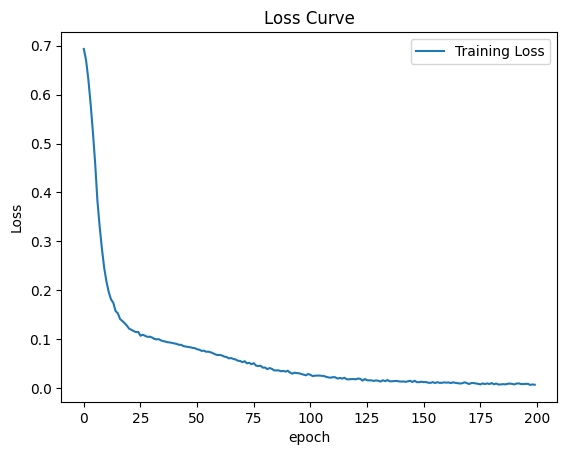

In [112]:
epoches = list(range(len(train_losses)))
plt.plot(epoches, train_losses, label = "Training Loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend()
plt.title("Loss Curve")
plt.savefig("")

NameError: name 'test_target' is not defined